# 抓取博主数据
### 安装weibo_spider
```bash
python3 -m pip install weibo_spider
```
### 抓取博主主页内容
*注：weibo为输出目录，config.json为程序配置文件，可以设置抓取内容*
```bash
python3 -m weibo_spider --output_dir="weibo" --config_path="config.json"
```

# 读取抓取数据

In [1]:
import pandas as pd
df = pd.read_csv("少数派sspai/1914010467.csv")
article=df["微博正文"]
likes=df["点赞数"]

# 生成帖子词云

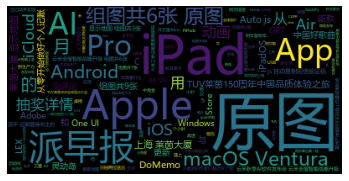

In [2]:
from wordcloud import WordCloud
import PIL .Image as image
text = " ".join(i for i in article)
wordcloud=WordCloud(font_path="msyh.ttc").generate(text)
word_image=wordcloud.to_image()
word_image.save('convert.png','png')
# 显示图片
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

lena = mpimg.imread('convert.png')
plt.imshow(lena)
plt.axis('off')
plt.show()

# 帖子热度统计

In [ ]:
# 导入字体管理库
from matplotlib import font_manager
likes=df.loc[:,"点赞数"]
comment=df.loc[:,"评论数"]
forward=df.loc[:,"转发数"]
time=df.loc[:,"发布时间"]
my_font = font_manager.FontProperties(fname=r"msyh.ttc")
plt.figure(figsize=(15,8),dpi=80)
plt.plot(range(len(likes)), likes, label='点赞数',color="r")
plt.plot(range(len(comment)), comment, label='评论数',color="b")
plt.plot(range(len(forward)), forward, label='转发数',color="y")
# 设置x，y坐标
plt.xticks(time)
plt.yticks(range(500))
# 设置网格线
plt.grid(alpha=0.2)
plt.legend(prop=my_font,loc="upper left")
plt.title('微博热度折线图',fontproperties=my_font)
plt.show()
plt.savefig('./hot.png')



# 爬取微博热搜

In [ ]:
import requests
import json
from bs4 import BeautifulSoup
import schedule
import time
import csv
from xlutils.copy import copy
url = 'https://s.weibo.com/top/summary?Refer=top_hot&topnav=1&wvr=6'
with open('微博热搜.csv', 'a+', newline='') as f:
    f_csv = csv.writer(f)
    f_csv.writerow(['时间', '排名', '热度', '内容'])
def run():
    header = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.54 Safari/537.36',
        'Cookie': 'WEIBOCN_WM=3349; MLOGIN=0; loginScene=102003; SUB=_2A25OZUb0DeRhGeFM71cR8SjPyTyIHXVtpmq8rDV6PUJbkdANLUTtkW1NQNrR0hDYvbkyXXHvhSXTK6gLZwPIvqhj; _T_WM=2f61b9622f544de949daf22f40ebcc99'
    }
    cookie = {
        'Cookie': ''
    }
    response = requests.get(url, headers=header, cookies=cookie)
    response.encoding = 'utf-8'
    soup = BeautifulSoup(response.text, 'html.parser')
    items = soup.find_all('td', class_='td-02')
    time_stamp = time.strftime('%Y/%m/%d %H:%M', time.localtime(time.time()))  # 时间戳

    for i, item in enumerate(items[1:11]):
        result = []
        rank = '第{0}名'.format(i+1)     # 微博排名
        num = str(item.find('span')).replace('<span>', '').replace('</span>', '')  # 微博热度
        title = item.find('a').text  # 微博内容
        result.append(time_stamp)
        result.append(rank)
        result.append(num)
        result.append(title)
        print(result)
        with open('微博热搜.csv', 'a+',newline='') as f:
            f_csv = csv.writer(f)
            f_csv.writerow(result)
    print(time_stamp)
run()
schedule.every(30).seconds.do(run)
while True:
    schedule.run_pending()

# 动态热搜图

In [24]:
from pyecharts import options as opts
from pyecharts.charts import Bar, Timeline,Grid
from pyecharts.globals import ThemeType
from pyecharts.commons.utils import JsCode
import pandas as pd
data=pd.read_csv('微博热搜.csv')
tl = Timeline({"theme": ThemeType.MACARONS})
for i in range(20):
    bar = (
        Bar({"theme": ThemeType.MACARONS})
        .add_xaxis(list(data['内容'])[i*10:i*10+10][::-1])
        .add_yaxis("微博热搜榜", list(data['热度'])[i*10:i*10+10][::-1])
        .reversal_axis()
        .set_global_opts(
            title_opts=opts.TitleOpts("{}".format(list(data['时间'])[i*10]),pos_right='0%',pos_bottom='15%'),
            xaxis_opts=opts.AxisOpts(
                splitline_opts=opts.SplitLineOpts(is_show=True),
                position='top',
                name_gap=10,
                boundary_gap=['20%', '20%']),
            yaxis_opts=opts.AxisOpts(splitline_opts=opts.SplitLineOpts(is_show=True),
                                     axislabel_opts=opts.LabelOpts(color='#FF7F50')),)
        .set_series_opts(label_opts=opts.LabelOpts(position="right",color='#9400D3'))
    )
    grid = (
        Grid()
        .add(bar, grid_opts=opts.GridOpts(pos_left="25%",pos_right="0%"))
    )
    tl.add(grid, "{}年".format(i))
    tl.add_schema(
        play_interval=1000,   #播放速度
        is_timeline_show=False,  #显示timeline 组件
        is_auto_play=True,  #自动播放
    )
tl.render_notebook()

# 生成热搜词云

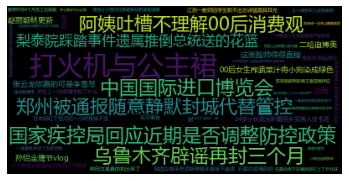

In [5]:
from wordcloud import WordCloud
import PIL .Image as image
hots=df['标题']
text = " ".join(i for i in hots)
wordcloud=WordCloud(font_path="msyh.ttc").generate(text)
word_image=wordcloud.to_image()
word_image.save('convert.png','png')
# 显示图片
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

lena = mpimg.imread('convert.png')
plt.imshow(lena)
plt.axis('off')
plt.show()